In [6]:
import mmf_setup;mmf_setup.nbinit(hgroot=False)
from mmfutils.contexts import NoInterrupt
from mmfutils.plot import imcontourf
from importlib import reload  # Python 3.4+
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import quad
from uncertainties import ufloat
import homogeneous;reload(homogeneous)
import bcs;reload(bcs)
from bcs import BCS
import vortex_1d_aslda;reload(vortex_1d_aslda)
import vortex_2d_aslda;reload(vortex_2d_aslda)
import itertools  
from IPython.display import display, clear_output
%pylab inline --no-import-all

<IPython.core.display.Javascript object>

Populating the interactive namespace from numpy and matplotlib


In [7]:
hbar = 1
m = 1
mu_eff = 1.0
n = 1.0
e_F = 1.0
k_F = np.sqrt(2*m*e_F)
n_F = k_F**3/3/np.pi**2
E_FG = 2./3*n_F*e_F
mu = 0.59060550703283853378393810185221521748413488992993*e_F #I change this number
delta = 0.68640205206984016444108204356564421137062514068346*e_F
grid_size = 64
lda = vortex_1d_aslda.ASLDA(Nx=grid_size)
k_c = abs(lda.kx[0]).max()
E_c = (lda.hbar*k_c)**2/2/lda.m
lda = vortex_1d_aslda.ASLDA(Nx=grid_size, Lx=np.pi, E_c=E_c)

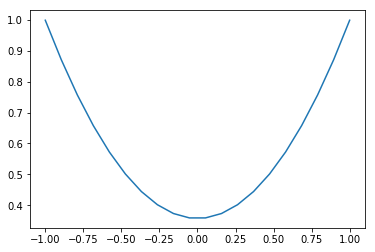

In [8]:
ps = np.linspace(-1,1,20)
plt.plot(ps,lda._G(ps))

Test the g(x) built in the functional, it should be very similar to the curve in Fig 1(PRL 101, 215301 (2008))

In [9]:
def g(x):
    p = (1-x)/(1+x)
    G = lda._G(p)
    g = (G /((1+p)/2)**(5/3))**(3/5)
    return g
def ns(x):
    return (1/(1+x),x/(1+x))

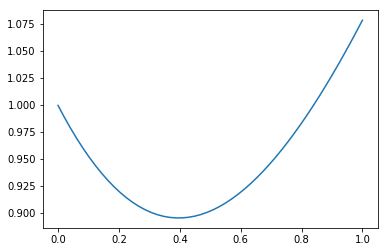

In [10]:
x = np.linspace(0,1,50)
plt.plot(x,g(x))

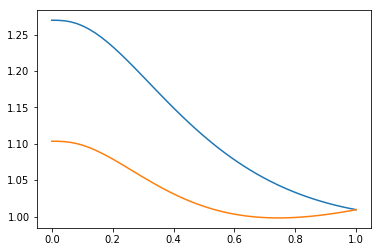

In [11]:
plt.plot(x,lda._alpha_a(*ns(x)))
plt.plot(x,lda._alpha_b(*ns(x)))

In [12]:
class ASLDA_(vortex_1d_aslda.ASLDA):
# a modified class from ASLDA with different alphas which are constant, so their derivatives are zero
    def get_alphas(self, ns = None):
        alpha_a,alpha_b,alpha_p =np.ones(self.Nx),np.ones(self.Nx),np.ones(self.Nx)
        return (alpha_a,alpha_b,alpha_p)       
        #return super().get_alphas(ns)
    def _dp_dn(self,ns):
        return (ns[0] * 0, ns[1]*0)
    
def iterate(lda, mudelta, na_avg=0.5, nb_avg=0.5, N_twist=0, **kw):
    mu_a, mu_b, na,nb, mu_a_eff, mu_b_eff, delta,taus,kappa = mudelta
    mus = (mu_a_eff, mu_b_eff)
    if na is None:
        na = np.ones(lda.Nx) * na_avg
    if nb is None:
        nb = np.ones(lda.Nx) * nb_avg
    #H = lda.get_H(mus=mus,delta = delta,ns=(na,nb),taus = taus,kappa=kappa)
    #if taus is not None:
    #    taus[1]=-1 * taus[1]
    ns_,taus_,kappa_ = lda.get_ns_taus_kappa_average_3d(mus=mus,delta = delta,ns=(na,nb),taus = taus,kappa=kappa,N_twist=N_twist) #lda.get_ns_taus_kappa(H) 
       
    gx = lda.gx(ns_,taus_,kappa_)
    na_,nb_ = ns_ # the new densities are not used in the iteration, just used for compute new mus
    nomral_na = na_.mean() / (na_.mean() + nb_.mean())
    nomral_nb = nb_.mean() / (na_.mean() + nb_.mean())
    mu_a = mu_a*(1 + (na_avg - nomral_na))
    mu_b = mu_b*(1 + (nb_avg - nomral_nb))
    lr = 0.4
    lo = 1 - lr
    v_a,v_b = lda.get_modified_Vs(delta=delta,ns=(na_,nb_),taus=taus_,kappa=kappa_,alphas=lda.get_alphas((na_,nb_)))
    mu_a_eff = mu_a + v_a * nb
    mu_b_eff = mu_b + v_b * na
    #delta = lda.g_eff*kappa 
    print(mu_a_eff.real.max(),mu_b_eff.real.max(),delta.real.max(), na_.real.mean(), nb_.real.mean(),gx.real.mean())
    return (mu_a, mu_b,lo*na + lr*na_,lo*nb + lr*nb_, mu_a_eff, mu_b_eff, delta,taus_,kappa_)


In [13]:
def test_iterate_ASLDA(N=5):
    N_twist=1
    grid_size = 8
    aslda = ASLDA_(Nx=grid_size)
    k_c = abs(aslda.kx).max()
    E_c = (aslda.hbar*k_c)**2/2/aslda.m # 3 dimension, so E_c should have a factor of 3
    aslda = ASLDA_(Nx=grid_size, Lx=0.46, E_c=E_c)
    mu_eff = 1.0
    k_F = np.sqrt(2*m*E_c)
    n_F = k_F**3/3/np.pi**2
    E_FG = 2./3*n_F*E_c
    mu = 1# 0.59060550703283853378393810185221521748413488992993*E_c
    delta = 0# 0.68640205206984016444108204356564421137062514068346*E_c
    qT = (mu, mu) +(None,None)+ (mu_eff*np.ones(aslda.Nx),)*2 + (delta * np.ones((aslda.Nx),), None,None)
    max_iteration = 5
    v_0, n, mu, e_0 = homogeneous.get_BCS_v_n_e(delta=delta, mu_eff=mu_eff)
    x = 1
    with NoInterrupt(ignore=True) as interrupted:
        while max_iteration > 0 and not interrupted:
            if N < 0:
                break
            N = N - 1
            qT = iterate(lda=aslda,mudelta = qT, N_twist=N_twist,na_avg=1/(1+x), nb_avg=x/(1+x), abs_tol=1e-2)
            mu_a, mu_b, na,nb, mu_a_eff, mu_b_eff, delta,taus,kappa = qT
            fig, axs = plt.subplots(nrows=1, ncols=2)
            clear_output(wait=True)
            plt1,plt2 = axs[0],axs[1]
            plt1.plot(aslda.x,na.real)
            plt1.plot(aslda.x,nb.real)
            plt2.plot(aslda.x,mu_a_eff.real)
            plt2.plot(aslda.x,mu_b_eff.real)
            display(plt.gcf())
            plt.gcf().clear()

In [14]:
test_iterate_ASLDA(10)

E:\Projects\Physics\quantum-fermion-theories\quantum-turbulence\homogeneous.py:18: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  res0, err0 = sp.integrate.quad(f, k_0, kF)
E:\Projects\Physics\quantum-fermion-theories\quantum-turbulence\homogeneous.py:19: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  res1, err1 = sp.integrate.quad(f, kF, k_inf, limit=limit)
E:\Projects\Physics\quantum-fermion-theories\quantum-turbulence\homogeneous.py:24: UserWarning: Gap integral did not converge: res, err = 54.3409, 5.70889
  warnings.warn("Gap integral did not converge: res, err = %g, %g" % (res, err))


AssertionError: 

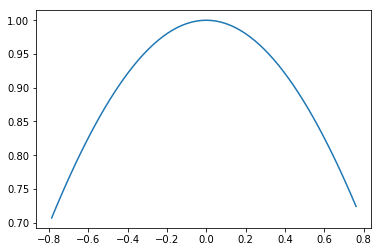

In [182]:
xs = 0.5*lda.x#np.linspace(-np.pi,np.pi,lda.Nx)
f = np.sin(xs)
g = np.cos(xs)
#plt.plot(xs,f)
plt.plot(xs,g)

In [189]:
D1 = lda.get_nabla()
D2 = lda.get_D2()

In [216]:
g1 = D1.dot(f)
g2 = D2.dot(f)

c:\program files\python36\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


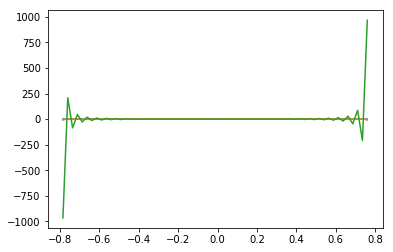

In [218]:
plt.plot(xs,g)
plt.plot(xs,g1)
plt.plot(xs,g2)

In [209]:
D = np.fft.ifft(-1j*lda.kx*np.fft.fft(np.eye(lda.Nx), axis=1), axis=1)

In [210]:
g__ = D.dot(f)

c:\program files\python36\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


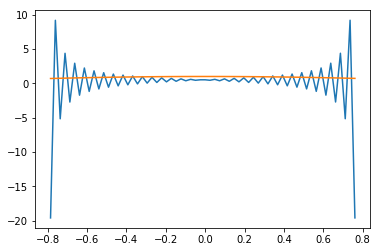

In [213]:
plt.plot(xs,g__)
plt.plot(xs,g)